### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

Описание данных - https://archive.ics.uci.edu/ml/machine-learning-databases/00222/

Эти данные связаны с прямыми маркетинговыми кампаниями португальского банковского учреждения. Маркетинговые кампании основывались на телефонных звонках. Часто требовалось более одного контакта с одним и тем же клиентом, чтобы получить доступ к тому, будет ли продукт (банковский срочный депозит) подписан ("да") или нет ("нет").

выходная переменная (желаемая цель):
21 - y - подписался ли клиент на срочный депозит? (двоичный код: "Да", "нет")

In [2]:
!pip install shap

  Using cached https://files.pythonhosted.org/packages/55/d6/d66cd49e8b4a710844e39b669bdde4cc83c76d05f02e1e0ecd2c0a9228f8/shap-0.37.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/02/a6/c708c5a0f338e99cfbcb6288b88794525548e4fc1b8457feec2c552a81a4/slicer-0.0.3-py3-none-any.whl


In [31]:
import shap
import xgboost

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
data = pd.read_csv("bank-full.csv", sep=';')
data.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


Посмотрим на типы данных

In [33]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [34]:
data['default'].value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [35]:
data['housing'].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [36]:
data['loan'].value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

In [37]:
data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [38]:
data['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [39]:
data['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [40]:
data['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [41]:
data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [ ]:
Сделайте замену значений default, housing, loan, y, contact, marital на числовые

In [42]:
def change_data(data, column):
    data.loc[data[column] == 'yes', column] = 1
    data.loc[data[column] == 'no', column] = 0
    return data

In [43]:
data = change_data(data, 'default')
data = change_data(data, 'housing')
data = change_data(data, 'loan')
data = change_data(data, 'y')

In [44]:
data.loc[data['contact'] == 'cellular','contact'] = 1
data.loc[data['contact'] == 'unknown','contact'] = 0
data.loc[data['contact'] == 'telephone','contact'] = 1

In [45]:
data.loc[data['marital'] == 'married','marital'] = 1
data.loc[data['marital'] == 'single','marital'] = 0
data.loc[data['marital'] == 'divorced','marital'] = 0

In [46]:
data.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,1,tertiary,0,2143,1,0,0,5,may,261,1,-1,0,unknown,0
1,44,technician,0,secondary,0,29,1,0,0,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,1,secondary,0,2,1,1,0,5,may,76,1,-1,0,unknown,0


Удалим значения day, month

In [47]:
data.drop(['day', 'month'], axis='columns', inplace=True)

Преобразуем категориальные признаки в бинарные

In [48]:
transform_data = pd.get_dummies(data)
transform_data.columns

Index(['age', 'marital', 'default', 'balance', 'housing', 'loan', 'contact',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [49]:
data = transform_data

In [50]:
data.head(3)

,age,marital,default,balance,housing,loan,contact,duration,campaign,pdays,...,job_unemployed,job_unknown,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,1,0,2143,1,0,0,261,1,-1,...,0,0,0,0,1,0,0,0,0,1
1,44,0,0,29,1,0,0,151,1,-1,...,0,0,0,1,0,0,0,0,0,1
2,33,1,0,2,1,1,0,76,1,-1,...,0,0,0,1,0,0,0,0,0,1


In [51]:
data.rename(columns={'y': 'target'}, inplace=True)

In [52]:
data.columns

Index(['age', 'marital', 'default', 'balance', 'housing', 'loan', 'contact',
       'duration', 'campaign', 'pdays', 'previous', 'target', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [53]:
features = ['age', 'marital', 'default', 'balance', 'housing', 'loan', 'contact',
       'duration', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown']

In [54]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data[features], data['target'], random_state=42)

In [58]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). Признаки, вклад которых сдвигает прогноз "вверх" помечены красным цветом, а другие - синим

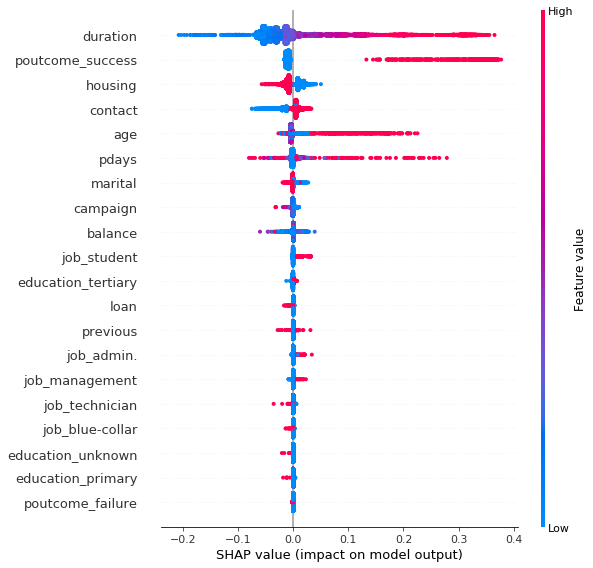

In [59]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

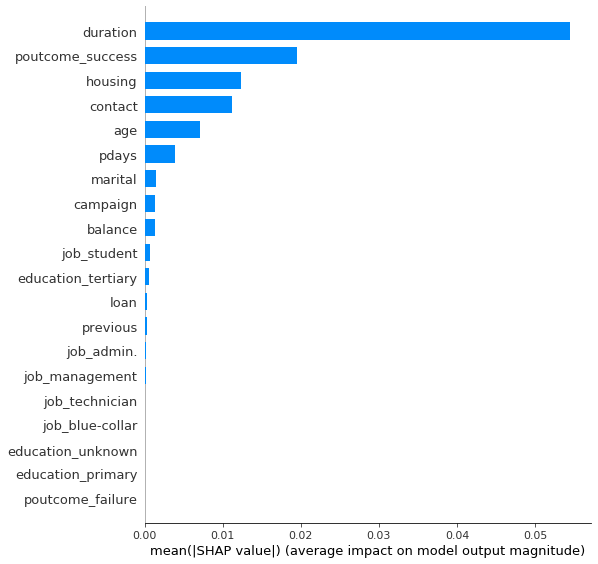

In [60]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

мы видим что наибольний вклад вносят признаки: длительности контакта, отсутсвие результатов предыдущих маркетинговых компаний, наличие кредитного жилья, отсутсвие контакта и возраст

очень длительны контакт негативно влияет на результат, наличие или отсутсвие кридитного жилья в равной степени, чем старше человек, тем вероятнее, что он подпишется на депозит

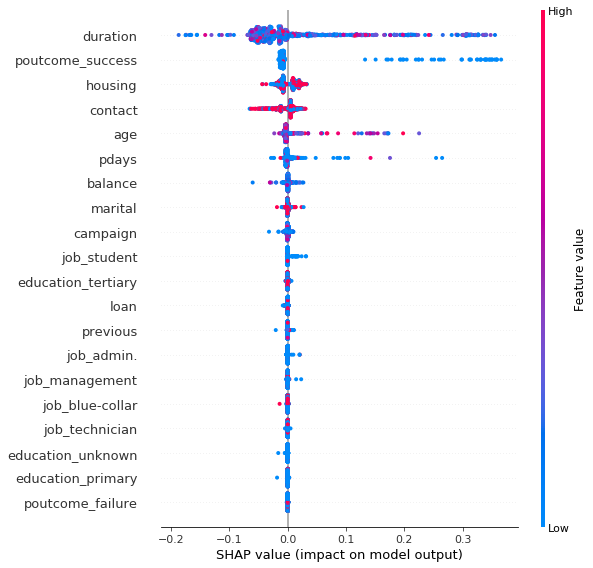

In [61]:
pers = int(len(shap_values)*0.1)
shap_values_short = np.sort(shap_values[:pers], axis = 0)
shap.summary_plot(shap_values_short, X_test[:pers])

In [62]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [63]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

In [64]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])

In [65]:
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

Можно отметить, что для каждого отдельного наблюдения вклад признаков приблизительно одинаковый, как у всей модели. 